<a href="https://colab.research.google.com/github/kasheena/Flower-Recognition-and-Classification-using-CNN/blob/main/FlowerRecognitionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
import os
os.chdir("/content/drive/My Drive/content")
!ls

flowers


In [49]:
import os
print(os.listdir('/content/drive/My Drive/content/flowers'))
#print(os.listdir('/content/drive/My Drive/flowers/flowers'))

['sunflower', 'daisy', 'rose', 'tulip', 'dandelion']


In [16]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [50]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='/content/drive/MyDrive/content/flowers/daisy'
FLOWER_SUNFLOWER_DIR='/content/drive/MyDrive/content/flowers/sunflower'
FLOWER_TULIP_DIR='/content/drive/MyDrive/content/flowers/tulip'
FLOWER_DANDI_DIR='/content/drive/MyDrive/content/flowers/dandelion'
FLOWER_ROSE_DIR='/content/drive/MyDrive/content/flowers/rose'

In [51]:
def assign_label(img,flower_type):
    return flower_type
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [52]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

0it [00:00, ?it/s]

0


In [53]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 733/733 [00:05<00:00, 141.69it/s]

733


In [54]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 332/332 [00:02<00:00, 125.87it/s]

1065


In [55]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:06<00:00, 147.14it/s]

2049


In [56]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:04<00:00, 159.07it/s]

2833


In [57]:
list(set(Z))

['Rose', 'Sunflower', 'Dandelion', 'Tulip']

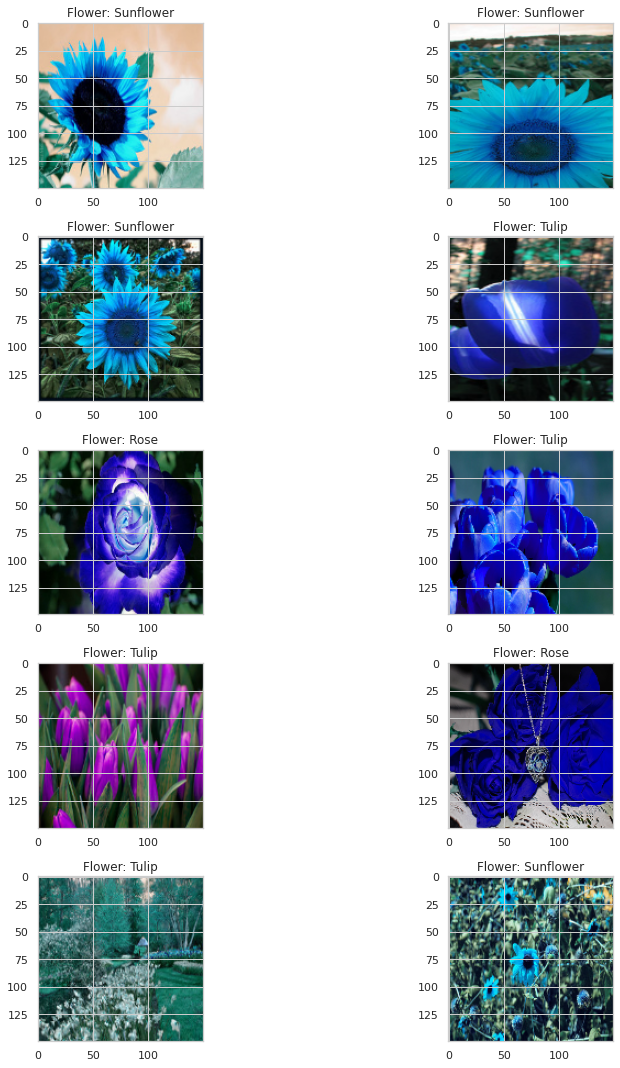

In [58]:
#Visualizing some Random Images
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

In [59]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [60]:
#Splitting into Training and Validation Sets
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [ ]:
#Setting the Random Seeds
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

**Building the ConvNet **

In [61]:
# # modelling starts using a CNN.

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

In [62]:
#Using a LR Annealer
batch_size=128
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [63]:
#Data Augmentation to prevent Overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


**Compiling the Keras Model & Summary**

In [64]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 96)       0

In [65]:
#Fitting on the Training set and making predcitons on the Validation set
#History = model.fit_generator(x_train,y_train, 
                               #validation_data = (x_test,y_test),
                              #verbose = 1)
History = model.fit(x_train,y_train,validation_data = (x_test,y_test),epochs = 5)

Epoch 1/5
67/67 [==============================] - 140s 2s/step - loss: 1.1554 - accuracy: 0.4628 - val_loss: 1.0790 - val_accuracy: 0.5233
Epoch 2/5
67/67 [==============================] - 131s 2s/step - loss: 0.9359 - accuracy: 0.5951 - val_loss: 0.8409 - val_accuracy: 0.6544
Epoch 3/5
67/67 [==============================] - 116s 2s/step - loss: 0.8190 - accuracy: 0.6507 - val_loss: 0.8083 - val_accuracy: 0.6685
Epoch 4/5
67/67 [==============================] - 114s 2s/step - loss: 0.7289 - accuracy: 0.6987 - val_loss: 0.7541 - val_accuracy: 0.6700
Epoch 5/5
67/67 [==============================] - 114s 2s/step - loss: 0.6563 - accuracy: 0.7283 - val_loss: 0.7410 - val_accuracy: 0.6883


In [66]:
History.history

{'loss': [1.1553643941879272,
  0.9359026551246643,
  0.8189947009086609,
  0.7288601994514465,
  0.656292736530304],
 'accuracy': [0.46280601620674133,
  0.5951035618782043,
  0.6506591439247131,
  0.6986817121505737,
  0.7283427715301514],
 'val_loss': [1.0789637565612793,
  0.8408640623092651,
  0.8082672953605652,
  0.7541253566741943,
  0.7409749627113342],
 'val_accuracy': [0.5232722163200378,
  0.6544429063796997,
  0.6685472726821899,
  0.66995769739151,
  0.6882933974266052]}

**Evaluating the Model Performance**

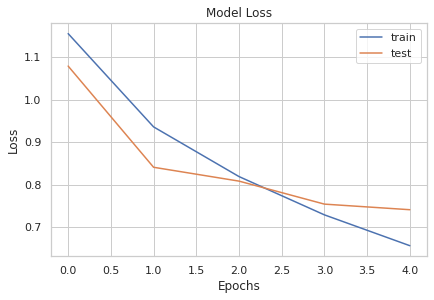

In [67]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

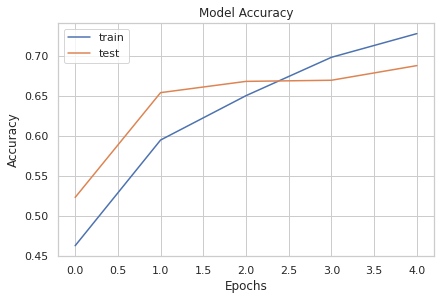

In [68]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

**Visualizing Predictons on the Validation Set**

In [69]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break
prop_class


23/23 [==============================] - 9s 403ms/step


[1, 2, 3, 4, 6, 9, 10, 11]

In [70]:
mis_class

[0, 5, 7, 8, 13, 15, 17, 28]

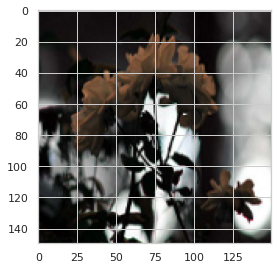

In [71]:
plt.imshow(x_test[1])

In [72]:
np.argmax(y_test[1],axis = 0)

pred_digits[1]

1

**CORRECTLY CLASSIFIED FLOWER IMAGES**

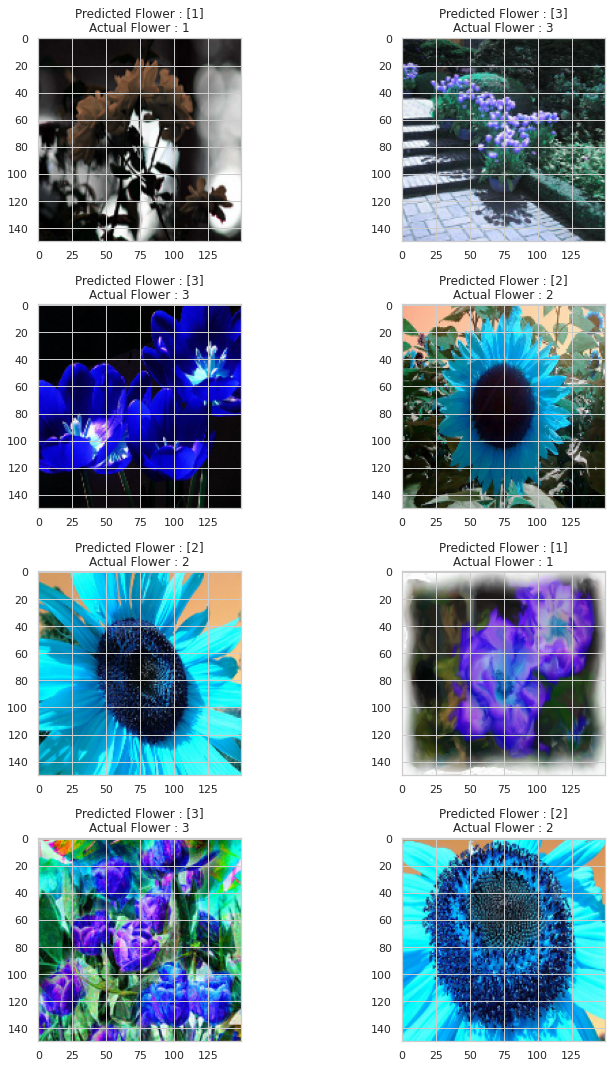

In [73]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str([pred_digits[prop_class[count]]])+"\n"+"Actual Flower : "+str(np.argmax(y_test[prop_class[count]])))
        plt.tight_layout()
        count+=1

**MISCLASSIFIED IMAGES OF FLOWERS**

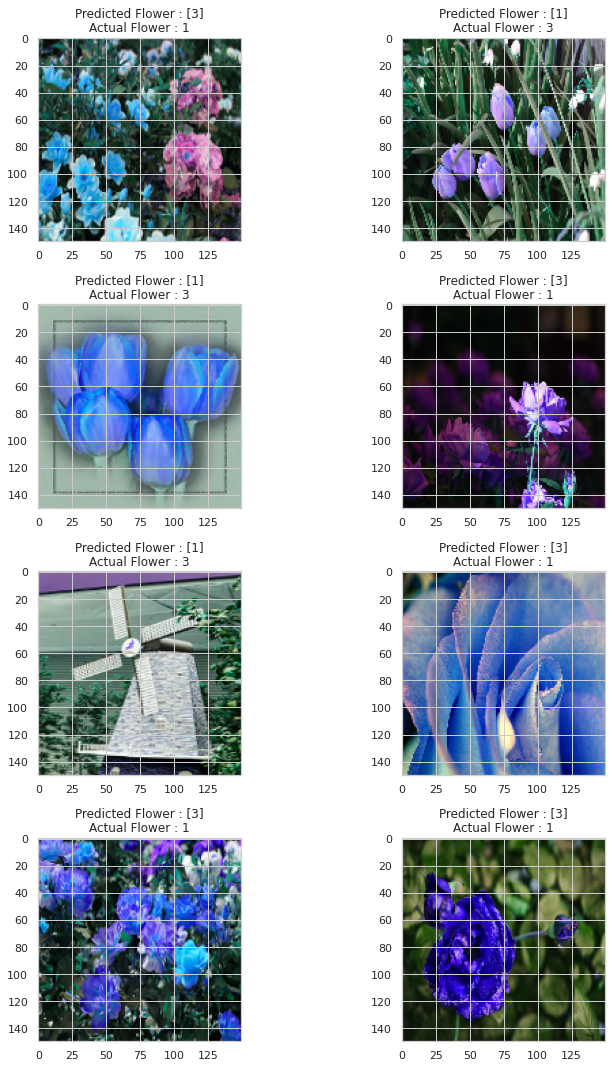

In [74]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])

        ax[i,j].set_title("Predicted Flower : "+str([pred_digits[mis_class[count]]])+"\n"+"Actual Flower : "+str(np.argmax(y_test[mis_class[count]])))        
        plt.tight_layout()
        count+=1